In [1]:
import openmc
import openmc_geometry_plot  # adds extra plotting functions to openmc.Geometry object\n",
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import openmc_source_plotter
from math import pi, sin, cos, sqrt

In [2]:
air = openmc.Material(name="Air")
air.set_density("g/cc", 0.001205)
air.add_element("N", 0.784431)
air.add_element("O", 0.210748)
air.add_element("Ar", 0.0046)

concrete = openmc.Material(name="concrete")
concrete.set_density("g/cm3", 3.6)
concrete.add_element("H", 0.006)
concrete.add_element("C", 0.00)
concrete.add_element("O", 0.589)
concrete.add_element("Na", 0.00)
concrete.add_element("Mg", 0.00)
concrete.add_element("Al", 0.006)
concrete.add_element("Si", 0.078)
concrete.add_element("P", 0.00)
concrete.add_element("S", 0.00)
concrete.add_element("Cl", 0.00)
concrete.add_element("K", 0.00)
concrete.add_element("Ca", 0.078)
concrete.add_element("Ti", 0.00)
concrete.add_element("V", 0.000)
concrete.add_element("Cr", 0.00)
concrete.add_element("Mn", 0.00)
concrete.add_element("Fe", 0.0709)
concrete.add_element("Ni", 0.015)
concrete.add_element("Cu", 0.00)
concrete.add_element("Zn", 0.00)
concrete.add_element("Sr", 0.00)
concrete.add_element("Ba", 0.00)
concrete.add_element("Bi", 0.00)
concrete.add_element("W", 0.03)
concrete.add_element("B", 0.127)
concrete.add_element("Pb", 0.0)

steel = openmc.Material(name="steel")
steel.set_density("g/cm3", 7.8)
steel.add_element("Fe", 0.97)
steel.add_element("C", 0.03)

materials = openmc.Materials([air, concrete, steel])
materials.export_to_xml()


In [3]:
height = 5000
outer_radius = 2500
thickness = 50

outer_cylinder = openmc.ZCylinder(r=outer_radius)
inner_cylinder = openmc.ZCylinder(r=outer_radius-thickness)
inner_top = openmc.ZPlane(z0=height*0.5)
inner_bottom = openmc.ZPlane(z0=-height*0.5)
outer_top = openmc.ZPlane(z0=(height*0.5)+thickness)
outer_bottom = openmc.ZPlane(z0=(-height*0.5)-thickness)

# this shpere_1 are used to tally the dose
sphere_1 = openmc.Sphere(r=5000)
# can't actually tally on the end of universe sphere hence sphere 1 is needed
sphere_2 = openmc.Sphere(r=5100, boundary_type='vacuum')

cylinder_region = -outer_cylinder & +inner_cylinder & -inner_top & +inner_bottom
cylinder_cell = openmc.Cell(region=cylinder_region)
cylinder_cell.fill = concrete

top_cap_region = -outer_top & +inner_top & -outer_cylinder
top_cap_cell = openmc.Cell(region=top_cap_region)
top_cap_cell.fill = concrete

bottom_cap_region = +outer_bottom & -inner_bottom & -outer_cylinder
bottom_cap_cell = openmc.Cell(region=bottom_cap_region)
bottom_cap_cell.fill = concrete

inner_void_region = -inner_cylinder & -inner_top & +inner_bottom
inner_void_cell = openmc.Cell(region=inner_void_region)
inner_void_cell.fill = air

# sphere 1 region is below -sphere_1 and not (~) in the other regions
sphere_1_region = -sphere_1
sphere_1_cell = openmc.Cell(
    region= sphere_1_region
    & ~bottom_cap_region
    & ~top_cap_region
    & ~cylinder_region
    & ~inner_void_region
)

sphere_2_region = +sphere_1 & -sphere_2
sphere_2_cell = openmc.Cell(region= sphere_2_region)

my_geometry = openmc.Geometry([
    inner_void_cell, cylinder_cell, top_cap_cell,
    bottom_cap_cell, sphere_1_cell, sphere_2_cell])

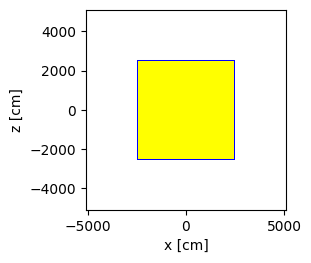

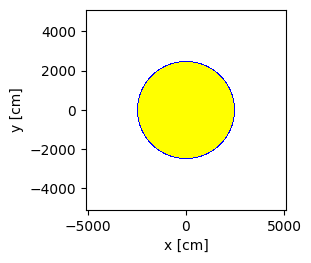

In [4]:
import matplotlib.pyplot as plt
color_assignment = {sphere_1_cell: 'grey',
                    sphere_2_cell: 'grey',
                    inner_void_cell: 'grey',
                    bottom_cap_cell: 'red',
                    top_cap_cell: 'blue',
                    cylinder_cell:'yellow',
                   }
x, y = 5200, 5200
plot = my_geometry.plot(basis='xz', color_by='material', colors=color_assignment) 


plot = my_geometry.plot(basis='xy', color_by='material', colors=color_assignment) 


In [5]:
# Instantiate a Settings object
my_settings = openmc.Settings()
my_settings.batches = 10
my_settings.inactive = 0
my_settings.particles = 5000
my_settings.run_mode = 'fixed source'

# Create a gamma point source
my_source = openmc.IndependentSource()
my_source.space = openmc.stats.Point((0, 0, 0))
my_source.angle = openmc.stats.Isotropic()
# This is a Co60 source, see the task on sources to understand it
my_source.energy = openmc.stats.muir(e0=2e6, m_rat=5, kt=20000)
my_source.particle = 'neutron'
my_settings.source = my_source
my_settings.photon_transport = True

In [6]:
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(particle='neutron',geometry='AP')
energy_bins_p, dose_coeffs_p = openmc.data.dose_coefficients(particle='photon', geometry='AP')

energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
energy_function_filter_n.interpolation = 'cubic'  # cubic interpolation is recommended by ICRP

energy_function_filter_p = openmc.EnergyFunctionFilter(energy_bins_p, dose_coeffs_p)
energy_function_filter_p.interpolation = 'cubic'  # cubic interpolation is recommended by ICRP

photon_particle_filter = openmc.ParticleFilter(["photon"])
surface_filter = openmc.SurfaceFilter(sphere_1)

dose_tally = openmc.Tally(name="dose_tally_on_surface")
dose_tally.scores = ["current"]
dose_tally.filters = [
    surface_filter,
    photon_particle_filter,
    energy_function_filter_p,
]
my_tallies = openmc.Tallies([dose_tally])

In [7]:
# Run OpenMC!
model = openmc.model.Model(my_geometry, materials, my_settings, my_tallies)
!rm *.h5
sp_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [8]:
import math

# open the results file
sp = openmc.StatePoint(sp_filename)

# access the tally using pandas dataframes
tally = sp.get_tally(name='dose_tally_on_surface')
df = tally.get_pandas_dataframe()

tally_result = df['mean'].sum()
tally_std_dev = df['std. dev.'].sum()

# convert from the tally output units of pSv cm² to pSv by dividing by the surface area of the surface
dose_in_pSv = tally_result / (4 * math.pi * math.pow(2500, 2))

source_activity = 56000
emission_rate = 5  
gamma_per_second = source_activity * emission_rate
dose_rate_in_pSv = dose_in_pSv * gamma_per_second*3600

# print results
print('The surface dose = ', dose_rate_in_pSv, 'pico Sv per hr')

The surface dose =  38.12625231862881 pico Sv per hr
